# 2048


In [1]:
import numpy as np
import random as rand
import time
from tkinter import *
import tkinter as tk

FONT = ("Verdana", 40, "bold")


class Env(tk.Tk):
    def __init__(self):
        super(Env, self).__init__()
        self.title('2048')
        self.geometry('{0}x{1}'.format(700, 800))
        self.SIZE = 500
        self.GRID_LEN = 4
        self.GRID_PADDING = 10
        self.BACKGROUND_COLOR_GAME = "#92877d"
        self.BACKGROUND_COLOR_CELL_EMPTY = "#9e948a"
        self.BACKGROUND_COLOR_DICT = {2: "#eee4da", 4: "#ede0c8", 8: "#f2b179", 16: "#f59563",
                                      32: "#f67c5f", 64: "#f65e3b", 128: "#edcf72", 256: "#edcc61",
                                      512: "#edc850", 1024: "#edc53f", 2048: "#edc22e"}

        self.CELL_COLOR_DICT = {2: "#776e65", 4: "#776e65", 8: "#f9f6f2", 16: "#f9f6f2",
                                32: "#f9f6f2", 64: "#f9f6f2", 128: "#f9f6f2", 256: "#f9f6f2",
                                512: "#f9f6f2", 1024: "#f9f6f2", 2048: "#f9f6f2"}
        self.grid_cells = []
        self.init_grid()
        self.init_matrix()
        self.action_space = ['u', 'd', 'l', 'r']
        self.action_size = len(self.action_space)
        self.counter = 0
        self.wait_visibility()

    def init_grid(self):
        self.background = tk.Frame(self, bg=self.BACKGROUND_COLOR_GAME, width=self.SIZE, height=self.SIZE)
        self.background.grid()
        for i in range(self.GRID_LEN):
            self.grid_row = []
            for j in range(self.GRID_LEN):
                self.cell = tk.Frame(self.background, bg=self.BACKGROUND_COLOR_CELL_EMPTY,
                                     width=self.SIZE / self.GRID_LEN, height=self.SIZE / self.GRID_LEN)
                self.cell.grid(row=i, column=j, padx=self.GRID_PADDING, pady=self.GRID_PADDING)
                # font = Font(size=FONT_SIZE, family=FONT_FAMILY, weight=FONT_WEIGHT)
                t = Label(master=self.cell, text="", bg=self.BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER, font=FONT,
                          width=4, height=2)
                t.grid()
                self.grid_row.append(t)

            self.grid_cells.append(self.grid_row)
        self.grid_row = []
        self.cell = tk.Frame(self.background, bg=self.BACKGROUND_COLOR_CELL_EMPTY, width=self.SIZE,
                             height=self.SIZE / self.GRID_LEN)
        self.cell.grid(row=4, columnspan=4, padx=self.GRID_PADDING, pady=self.GRID_PADDING, sticky=W + E + N + S)
        t = Label(master=self.cell, text="", bg=self.BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER, font=FONT, width=4,
                  height=2)
        t.grid(columnspan=4, ipadx=250)
        self.grid_row.append(t)
        self.grid_cells.append(self.grid_row)

    def init_matrix(self):
        self.game = Game(self.GRID_LEN)
        self.state = self.game.start()

    def render(self):
        time.sleep(0.01)
        self.update()

    def make_move(self, move=None):
        #         self.title.configure(f'2048 : {self.game.score}')
        #         print(self.game.score)

        #         output = 0 # 이 부분이 인공 신경망에서 전달해준 값을 바탕으로 선택된 action에 전달될 움직임 방향 -> 나중에 적용할 때 매개변수로 받고 환경에서 부르면 될듯
        #         move = rand.choice([0,1,2,3]) # np.argmax(output[0]) 이런식으로 신경망이 뱉어준 움직임을 선택하거나 따로 인덱스를 주거나 해서 선택하면 될듯
        self.game.move(move)
        self.state = self.game.getBord()
        return self.state

    def reset(self):
        self.game.reset()
        self.init_matrix()
        return self.game.getBord().reshape(-1, 1)

    def get_state(self):
        return self.state

    def step(self, action):
        self.counter += 1
        next_state = self.make_move(action).reshape(-1, 1)
        reward = self.game.getReward()
        done = self.game.isDone()
        for i in range(self.GRID_LEN):
            for j in range(self.GRID_LEN):
                new_number = self.state[i][j]
                if new_number == 0:
                    self.grid_cells[i][j].configure(text="", bg=self.BACKGROUND_COLOR_CELL_EMPTY)
                else:
                    self.grid_cells[i][j].configure(text=str(new_number), bg=self.BACKGROUND_COLOR_DICT[new_number],
                                                    fg=self.CELL_COLOR_DICT[new_number])
        self.grid_cells[4][0].configure(text="Game Score : {}".format(self.game.getScore()),
                                        bg=self.BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER)
        if done:
            self.grid_cells[1][1].configure(text="You", bg=self.BACKGROUND_COLOR_CELL_EMPTY)
            self.grid_cells[1][2].configure(text="Lose!", bg=self.BACKGROUND_COLOR_CELL_EMPTY)
            reward = self.game.getScore()
        return next_state, reward, done
    
    def close(self):
        self.destroy()



class Game:
    def __init__(self, size):
        self.size = size
        self.bord = np.zeros((self.size, self.size), dtype='int64')
        self.score = 0
        self.reward = 0
        self.done = False

    def findEmpty(self):
        # 빈칸을 확인해서 좌표 return / 없으면 None return
        z_list = np.array([[r, c] for r, c in zip(np.where(self.bord == 0)[0], np.where(self.bord == 0)[1])])
        if z_list.size == 0:
            return None
        location = rand.choice(z_list)
        return location

    def isfull(self):
        # bord가 숫자로 가득 차있는경우 True/ 빈칸이 있는경우 False 반환
        if 0 in self.bord.reshape(-1):
            return False
        else:
            return True

    def mkblock(self):
        # 빈칸에 확률에 맞춰서 2또는 4 블럭을 생성
        location = self.findEmpty()
        self.bord[location[0]][location[1]] = 2 if rand.random() < 0.9 else 4

    def merge(self, lstin):
        # 합치는 연산
        lst = lstin
        if lst.size != len(set(lst)):
            for t in range(lst.size - 1):
                if lst[t] == lst[t + 1]:
                    self.reward += lst[t]
                    lst[t] *= 2
                    lst[t + 1] = 0
            lst = lst[np.where(lst != 0)]
        return lst

    def move(self, index):
        self.reward = 0  # 움직이기 전에 보상을 초기화
        ismove = False  # 움직임 후 변화가 없는 경우에는 안 움직인 것으로 판단하기위해 설정
        # index에 따라 움직임
        # 움직임이 가능한지 확인하고
        #         print( self.canMove())
        if self.canMove():
            # 가능하다면 움직임 (0 - 상) (1 - 하) (2 - 좌) (3 - 우)
            if index == 0:
                for c in range(self.size):
                    col = self.bord[:, c][np.where(self.bord[:, c] != 0)]
                    col = self.merge(col)
                    pd = 4 - col.size
                    if np.any(self.bord[:, c] != np.pad(col, (0, pd))):
                        self.bord[:, c] = np.pad(col, (0, pd))
                        ismove = True

            elif index == 1:
                for c in range(self.size):
                    col = self.bord[:, c][np.where(self.bord[:, c] != 0)]
                    col = self.merge(col[::-1])[::-1]
                    pd = 4 - col.size
                    if np.any(self.bord[:, c] != np.pad(col, (pd, 0))):
                        self.bord[:, c] = np.pad(col, (pd, 0))
                        ismove = True

            elif index == 2:
                for r in range(self.size):
                    row = self.bord[r, :][np.where(self.bord[r, :] != 0)]
                    row = self.merge(row)
                    pd = 4 - row.size
                    if np.any(self.bord[r, :] != np.pad(row, (0, pd))):
                        self.bord[r, :] = np.pad(row, (0, pd))
                        ismove = True

            elif index == 3:
                for r in range(self.size):
                    row = self.bord[r, :][np.where(self.bord[r, :] != 0)]
                    row = self.merge(row[::-1])[::-1]
                    pd = 4 - row.size
                    if np.any(self.bord[r, :] != np.pad(row, (pd, 0))):
                        self.bord[r, :] = np.pad(row, (pd, 0))
                        ismove = True

            if ismove:  # 움직임이 있었던 경우에만 블럭 생성
                self.mkblock()
                self.score += self.reward
                self.reward = 10
        else:
            # 움직일 수 없는 경우는 게임종료
            self.gameOver()

    def canMove(self):
        # 움직임이 가능한지 확인 움직임이 가능하면 ture
        # 반환 불가능하면 게임 종료
        for i in range(self.size):
            for j in range(self.size - 1):
                if self.bord[i][j] == self.bord[i][j + 1]:
                    return True
        for j in range(self.size):
            for i in range(self.size - 1):
                if self.bord[i][j] == self.bord[i + 1][j]:
                    return True
        if not self.isfull():
            return True
        self.done = True
        return False

    def gameOver(self):
        # done 게임 종료 선언
        self.done = True
        self.reward = self.score

    def reset(self):
        self.bord = np.zeros((self.size, self.size), dtype='int64')
        self.score = 0
        self.reward = 0
        self.done = False

    def start(self):
        # 게임 시작
        self.mkblock()
        self.mkblock()
        return self.bord

    def getBord(self):
        return self.bord

    def getScore(self):
        return self.score

    def getReward(self):
        return self.reward

    def isDone(self):
        return self.done
    


In [2]:
import random
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
import matplotlib.pyplot as plt

EPISODES = 2000

class DQNAgent:
    def __init__(self, state_size, action_size, pretrain=False):
        self.load_model = pretrain
        self.render = True
        self.discount_factor = 0.99
        self.learning_rate = 0.01

        self.epsilon = 1.0
        self.epsilon_decay = 0.99999
        self.epsilon_min = 0.2

        self.batch_size = 128
        self.train_start = 1000

        self.queueLenMax = 3000
        self.memory = deque(maxlen=self.queueLenMax)

        self.perfWindowSize = 10
        self.penalty = -100

        self.nNodesLayer1 = 64
        self.nNodesLayer2 = 32

        self.state_size = state_size
        self.action_size = action_size

        self.model = self.build_model()
        self.target_model = self.build_model()

        self.update_target_model()  # set same weights at the first time

        if self.load_model:
            self.model.load_weights("./save_model/2048.h5")
            self.epsilon_decay = 1
            self.epsilon = 0
            self.epsilon_min = 0

    def build_model(self):
        model = Sequential()
        model.add(Dense(self.nNodesLayer1, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))  # , kernel_initializer ='he_uniform'))
        model.add(Dense(self.nNodesLayer2, activation='relu', kernel_initializer='he_uniform'))  # , kernel_initializer ='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))  # , kernel_initializer ='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        s = state.reshape(1, -1)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(s)
            return np.argmax(q_value[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []
        for i in range(self.batch_size):
            states[i] = mini_batch[i][0].reshape(-1)
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3].reshape(-1)
            dones.append(mini_batch[i][4])

        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        for i in range(self.batch_size):

            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 3,300
Trainable params: 3,300
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
________________________________

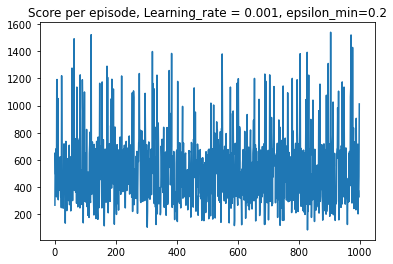

In [3]:
if __name__ == '__main__':
    env = Env()
    state_size = env.get_state().reshape(1, -1).shape[1]
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size, pretrain=False)

    maxScore = -np.inf


    s = []
    for i_episode in range(1000):
        state = env.reset()
        score = 0
        while True:
            if i_episode > 990:
                env.render()
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.append_sample(state, action, reward, next_state, done)
            state = next_state
            if (agent.load_model is False) and (len(agent.memory) >= agent.train_start):
                agent.train_model()

            if done:
                s.append(reward)
                print('Episode:', i_episode, ' score:', reward, ' memory length', len(agent.memory), ' epsilon:', agent.epsilon)
                if agent.load_model is False:
                    agent.update_target_model()
                    if reward > maxScore:
                        maxScore = reward
                        agent.model.save_weights('save_model/2048.h5')
                break
    plt.plot(s)
    plt.title('Score per episode, Learning_rate = {}, epsilon_min={}'.format(agent.learning_rate, agent.epsilon_min))
    plt.savefig('save_plt/Learning_rate={},epsilon_min={},Discount_factor={},episod={}.png'.format(agent.learning_rate, agent.epsilon_min, agent.discount_factor, i_episode+1), dpi=300, facecolor='w')
    plt.show()
    env.close()